In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from MPyDATA_examples.shallow_water.setup import Setup, S2D
from MPyDATA_examples.shallow_water.simulation import Simulation
from MPyDATA import Options

In [3]:
setup = Setup()
options = Options(n_iters = 2,
        infinite_gauge = True,
        divergent_flow = True,
        flux_corrected_transport = True
)

../..\MPyDATA_examples\shallow_water\setup.py:18: RuntimeWarning: invalid value encountered in sqrt
  self.tt = lambda x: 1 / 2 * (np.sqrt(x * (x - 1)) + np.log(np.sqrt(x - 1) + np.sqrt(x)))
C:\Users\Michael\anaconda3\lib\site-packages\pynverse\inverse.py:113: RuntimeWarning: invalid value encountered in sign
  trend = np.sign(func(ref2, *args) - func(ref1, *args))


# 1D case

## Formulation of the problem
basic assumptions:
   - horizontal scale is much larger than the vertical scale ($ u \approx u(x) $)
   - hydrostatic equillibrium
   - constant density

governing equations:
$$\partial_tH + \partial_x(uH) = 0 $$
$$ \partial_t(uH) + \partial_x(uuH) = - H \cdot \partial_xH $$

where $H$ is a normalised depth of the fluid layer and $u$ is a normalised velocity

first equation is just mass-continuity equation, to get second equation one may need momentum equation 

$$ \partial_t u + u \cdot \partial_x u = - \frac{1}{\rho} \partial_x p $$,
multiply it by $H$ and add $u$ multiplied by mass-continuity equation (taken in normalised units $g=1$), where p is the pressure in the constant-density fluid
$$ p = p_0 - \rho g z = p_0 + \rho g \cdot (H - z) $$


In [4]:
x = setup.grid
H0 = setup.H0(x)
H = lambda t: setup.analytic_H(x, t)
u = lambda t: setup.analytic_u(x,t)

## analytical solutions

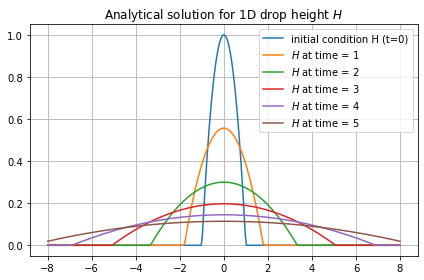

In [5]:
plt.title('Analytical solution for 1D drop height $H$')
plt.plot(x, H0, label = 'initial condition H (t=0)')
for nt in range(1,6):
    plt.plot(x, H(nt), label = f'$H$ at time = {nt}')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()

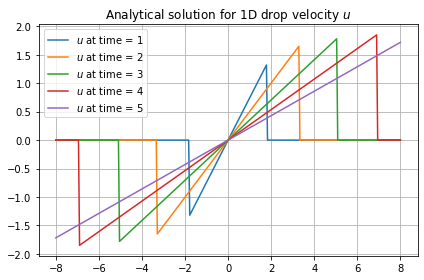

In [6]:
plt.title('Analytical solution for 1D drop velocity $u$')
for nt in range(1,6):
    plt.plot(x, u(nt), label = f'$u$ at time = {nt}')
plt.grid()
plt.legend(loc='best')
plt.tight_layout()

## numerical simulation using MPyDATA

the first of the governing equations for H is an homogenous "sink" type one, so it can be solved directly

In [7]:
def plot(simulation):
    plt.title("Numerical result  (with fake constant in space velocity $u$)")
    psi_0 = simulation.state
    simulation.run()
    psi_T = simulation.state
    plt.plot(x, psi_0, label = "initial condition")
    plt.plot(x, psi_T, label = f"result for t={setup.dt*setup.nt}")
    plt.grid()
    plt.legend(loc='best')
    plt.tight_layout()

In [8]:
simulation = Simulation(setup, options)

../..\MPyDATA_examples\shallow_water\setup.py:18: RuntimeWarning: invalid value encountered in sqrt
  self.tt = lambda x: 1 / 2 * (np.sqrt(x * (x - 1)) + np.log(np.sqrt(x - 1) + np.sqrt(x)))
C:\Users\Michael\anaconda3\lib\site-packages\pynverse\inverse.py:113: RuntimeWarning: invalid value encountered in sign
  trend = np.sign(func(ref2, *args) - func(ref1, *args))


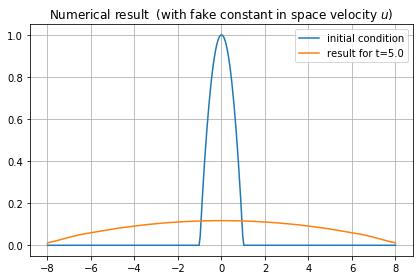

In [9]:
plot(simulation)

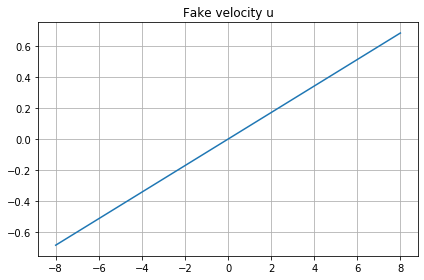

In [10]:
plt.title('Fake velocity u')
plt.plot(x, setup.C(x))
plt.grid()
plt.tight_layout()

### the real problem (both in 1D, and as will be seen later 2D) exists in the updating u field, because to do so one needs to consider second, non-homogenous equation, advecting field $\psi = uH$ again with velocity $u$ but this time with non-zero source term $R = -H\cdot\partial_x H$. To handle this we need to implement a second order-accurate Crank–Nicolson scheme (so called "trapez" option)

### 0. solving the homogenous equation for $H$ with $u_0 = 0$ velocity is redundant 
### 1. one should solve the second equation for $(uH)_1$ with the $rhs_0 = -H_0 \cdot \partial_x H_0 $
### 2. using trapesoidal rule $u_{1} = (uH)_1 / H_0 $
### 3. solve first equation for $H_1$ using $u_1$
### 4. recalculate $rhs_1 = - H_1 \cdot \partial_x H_1$ 
### 5 $(uH)_n$ using $rhs_{n-1}$


# extension for 2D case

extension for 2D case is pretty straightforward because of the symmetry of the problem with $\partial_x \longrightarrow \nabla$

## Formulation of the problem

governing equations:
$$\partial_tH + \partial_x(uH) + \partial_y(vH) = 0 $$
$$ \partial_t(uH) + \partial_x(uuH) + \partial_y(vuH) = - H \cdot \partial_xH $$
$$ \partial_t(uH) + \partial_x(uvH) + \partial_y(vvH) = - H \cdot \partial_yH $$

In [11]:
setup = S2D()

In [12]:
x, y = setup.xgrid, setup.ygrid
H0 = setup.H0(x, y)
Ht = lambda t: setup.analytic_H2(x,y,t)

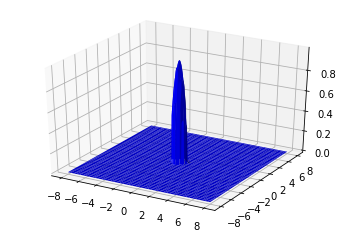

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, H0, color='b')
plt.show()

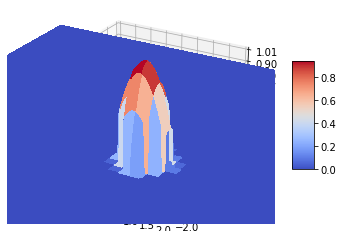

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, H0, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(0, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

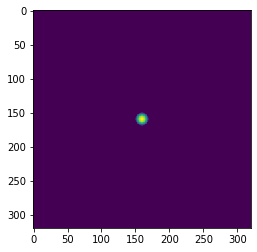

In [15]:
plt.imshow(Ht(0))

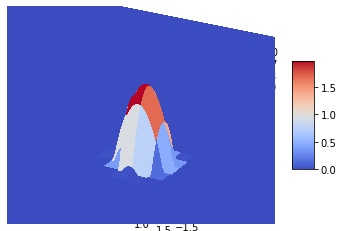

In [32]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, Ht(.4), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.set_zlim(0, 3)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

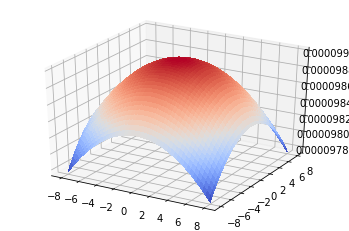

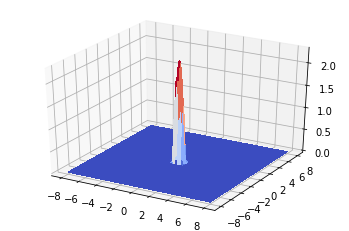

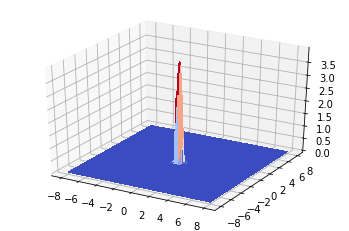

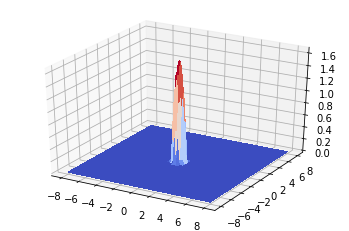

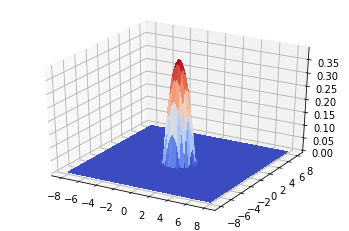

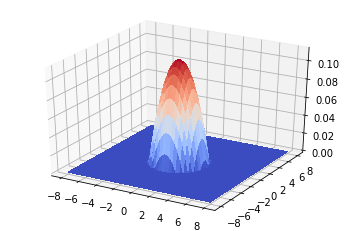

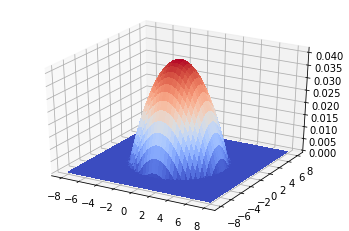

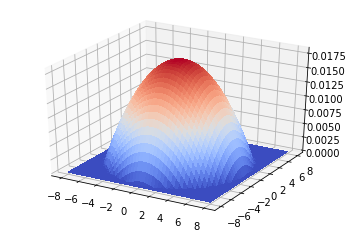

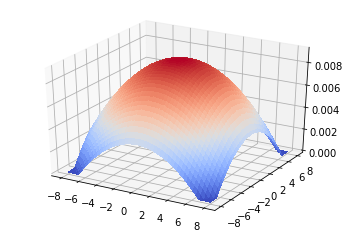

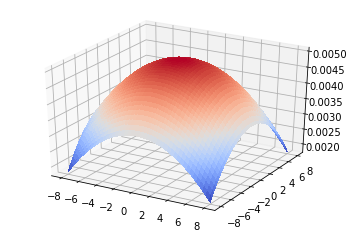

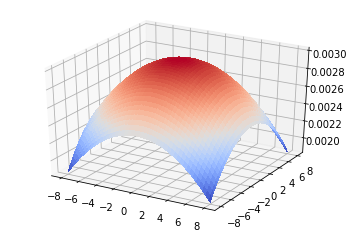

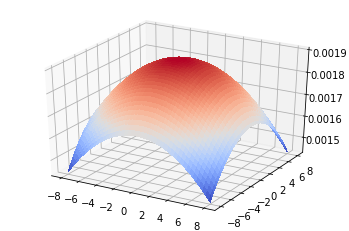

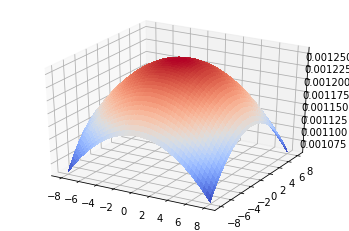

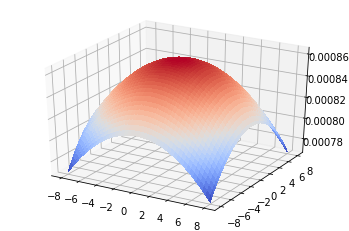

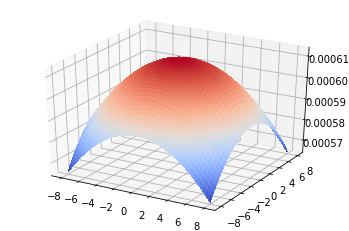

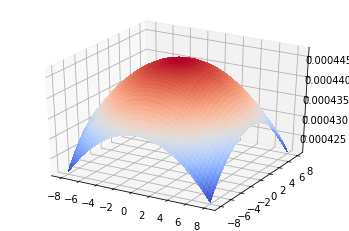

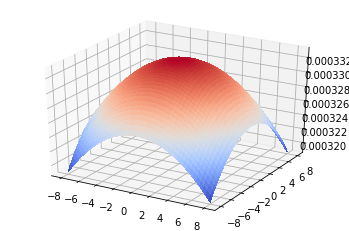

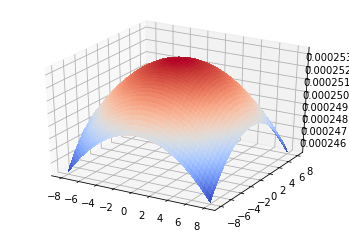

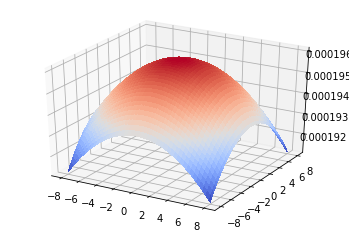

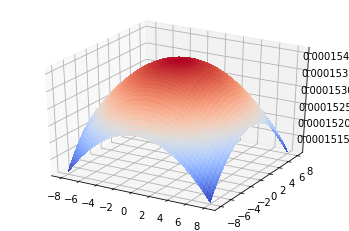

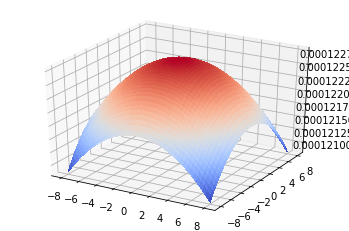

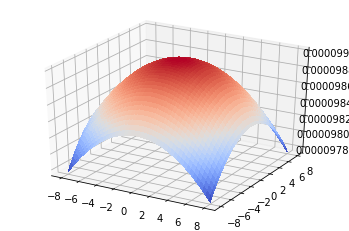

In [51]:
import matplotlib.animation
from IPython.display import display, clear_output
import time

t = np.linspace(0,10,20)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, Ht(.4), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

for dt in t:
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x, y, Ht(dt), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    clear_output()
    display(fig)
    time.sleep(.001)
